# Introduction to WaveNet
## Jonathan Balaban

WaveNet is a powerful new predictive technique that uses multiple Deep Learning (DL) strategies from Computer Vision (CV) and Audio Signal Processing models and applies them to longitudinal (time-series) data.

We'll explore WaveNet and how it works, but first dive into data prep, current high-performance models (as a baseline, Facebook Prophet), and then compare results!

>run this full line in bash, as one line:

`conda create -n wavenet python=3.7 pandas numpy seaborn matplotlib scipy patsy statsmodels jupyter fbprophet`

# Data Setup

In [14]:
import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#pd.core.common.is_list_like = pd.api.types.is_list_like
#from pandas_datareader import data
#from math import sqrt
#import quandl
#quandl.ApiConfig.api_key = "Xe_Akn13ZTp5zvsxoJs7"

In [15]:
# load Apple stock
aapl_raw = pd.read_csv('./AAPL-2000-2019.csv')
#stocks_list = []

# append to empty list
#for symbol in stocks['Symbol']:
    #stocks_list.append(symbol)

In [16]:
aapl_raw.info()

# we need to set date as datetime object and index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4779 entries, 0 to 4778
Data columns (total 7 columns):
Date         4779 non-null object
Open         4779 non-null float64
High         4779 non-null float64
Low          4779 non-null float64
Close        4779 non-null float64
Adj Close    4779 non-null float64
Volume       4779 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 261.4+ KB


In [17]:
aapl_raw.index = pd.to_datetime(aapl_raw.Date)

In [18]:
# check
aapl_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2000-04-18,2000-04-18,4.410714,4.531250,4.263393,4.531250,3.021451,97731200
2000-04-19,2000-04-19,4.506696,4.651786,4.276786,4.325893,2.884518,130037600
2000-04-20,2000-04-20,4.417411,4.455357,4.180804,4.245536,2.830937,180530000
2000-04-24,2000-04-24,4.107143,4.303571,4.098214,4.303571,2.869634,110905200
2000-04-25,2000-04-25,4.361607,4.598214,4.359375,4.582589,3.055684,97910400


In [19]:
# rename Adj Close to AC, get rid of pesky spacing
aapl_raw['AC'] = aapl_raw['Adj Close']

>Based on [this article](https://finance.zacks.com/adjusted-closing-price-vs-closing-price-9991.html) and others, let's use Adj Close as our series.

In [20]:
# calculate MACD (a key trading metric, and helpful exogenous variable)
aapl_raw['MACD'] = (aapl_raw.AC.ewm(span=12).mean() - aapl_raw.AC.ewm(span=26).mean())

>[MACD is often used by investors as a buy/sell indicator](https://www.investopedia.com/terms/m/macd.asp), so it should help track patterns and trend changes!

In [21]:
# good, now drop Date and everything but AC and Volume
aapl = aapl_raw.drop(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close'])
aapl.head()

,Volume,AC,MACD
Date,,,
2000-04-18,97731200,3.021451,0.000000
2000-04-19,130037600,2.884518,-0.003072
2000-04-20,180530000,2.830937,-0.005576
2000-04-24,110905200,2.869634,-0.005181
2000-04-25,97910400,3.055684,0.002546


In [22]:
aapl.describe().round(2)

,Volume,AC,MACD
count,4.779000e+03,4779.00,4779.00
mean,1.182295e+08,47.69,0.27
std,9.954219e+07,56.83,1.48
min,9.835000e+06,0.62,-10.81
25%,5.056905e+07,3.35,-0.05
50%,9.088870e+07,18.33,0.06
75%,1.547458e+08,87.48,0.54
max,1.855410e+09,230.28,7.16


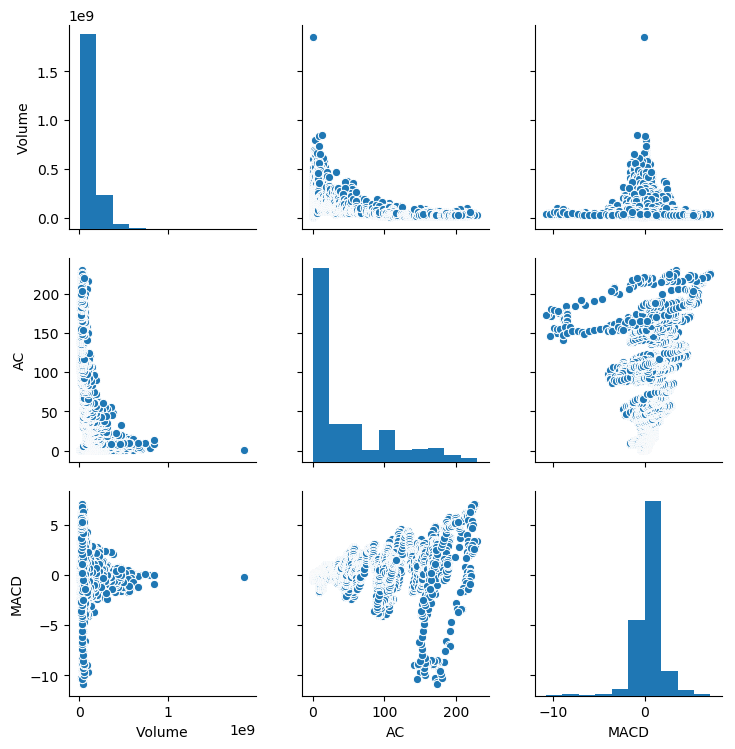

In [23]:
sns.pairplot(aapl);

We can note a few things from the EDA above:
- No NULLs
- Inverse exponential relationship between AC and Volume?
- Right skew in price

There's an important consideration also: **stock splits!**

Apple's stock has split four times since the company went public. The stock split on a 7-for-1 basis on June 9, 2014 and split on a 2-for-1 basis on February 28, 2005, June 21, 2000, and June 16, 1987.

Let's filter to the 2014 and 2005 weeks and see what happened:

In [24]:
# first 2005
#aapl['2005-02-24':'2005-03-02']

# looks like Adj Close accounted for the split automatically

In [25]:
# next 2014
#aapl['2014-06-06':'2014-06-11']

# good again, but essential to check!

## Statistics

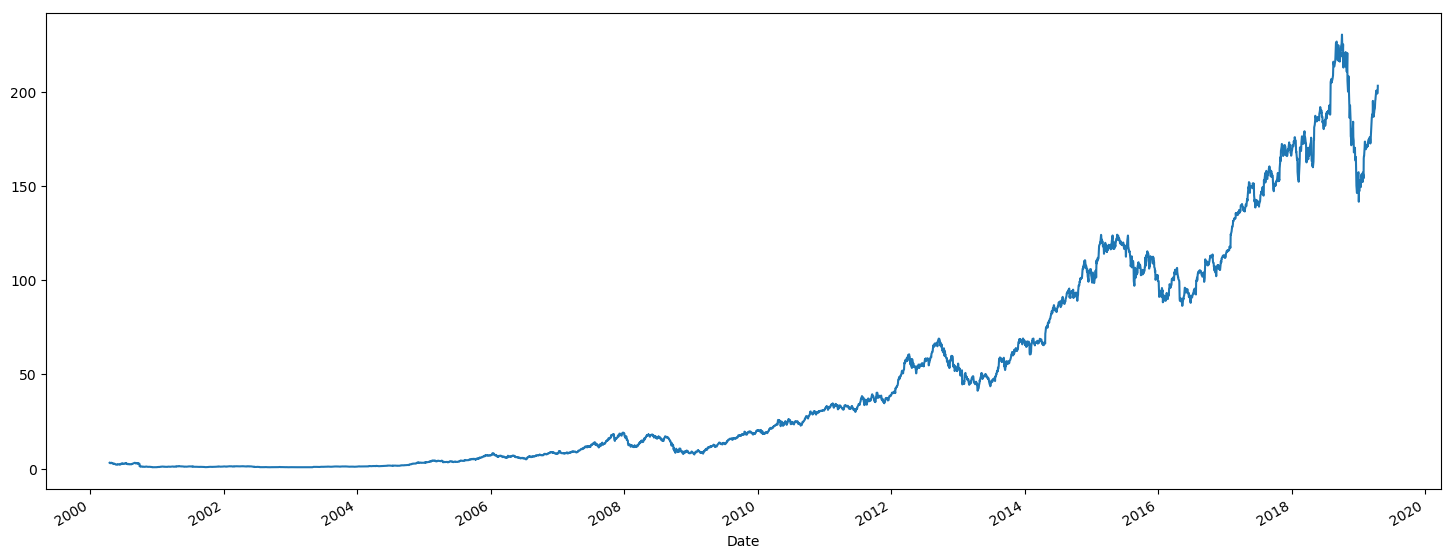

In [38]:
# plot price over time
aapl.AC.plot();

In [28]:
# Optional: run ADF to determine unit root
import statsmodels.tsa.stattools as ts
cadf = ts.adfuller(aapl_raw.AC)

print('Augmented Dickey Fuller:')
print('Test Statistic =',cadf[0])
print('p-value =',cadf[1])
print('Critical Values =',cadf[4])

Augmented Dickey Fuller:
Test Statistic = 1.0742834629100277
p-value = 0.9949910545329405
Critical Values = {'1%': -3.431728601011308, '5%': -2.862149185397661, '10%': -2.567094271358372}


# FB Prophet

In [29]:
from fbprophet import Prophet

# pull only close price and set up dataframe for prophet
aapl_fb = aapl
aapl_fb['ds'] = aapl_fb.index
aapl_fb = aapl_fb.rename(columns={'AC': 'y'})

In [30]:
aapl_fb.head()

,Volume,y,MACD,ds
Date,,,,
2000-04-18,97731200,3.021451,0.000000,2000-04-18
2000-04-19,130037600,2.884518,-0.003072,2000-04-19
2000-04-20,180530000,2.830937,-0.005576,2000-04-20
2000-04-24,110905200,2.869634,-0.005181,2000-04-24
2000-04-25,97910400,3.055684,0.002546,2000-04-25


In [31]:
# fit model without final thirty periods
fbm = Prophet(weekly_seasonality='auto', daily_seasonality=False, seasonality_mode='multiplicative')

fbm.fit(aapl_fb.iloc[:-30,:]);

# create future dataset
future = fbm.make_future_dataframe(periods=60, freq='D')
future.tail()

/Users/jb/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds
4804,2019-05-01
4805,2019-05-02
4806,2019-05-03
4807,2019-05-04
4808,2019-05-05


In [32]:
# check endpoint for train
aapl_fb.iloc[-30,:]

Volume               24760900
y                       172.5
MACD                  2.78684
ds        2019-03-07 00:00:00
Name: 2019-03-07 00:00:00, dtype: object

In [33]:
forecast = fbm.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4804,2019-05-01,197.060943,185.853910,207.696812
4805,2019-05-02,197.280958,186.134121,208.189560
4806,2019-05-03,197.374295,185.624110,208.257384
4807,2019-05-04,-312.980030,-323.573614,-300.852853
4808,2019-05-05,-312.779904,-323.964868,-302.316276


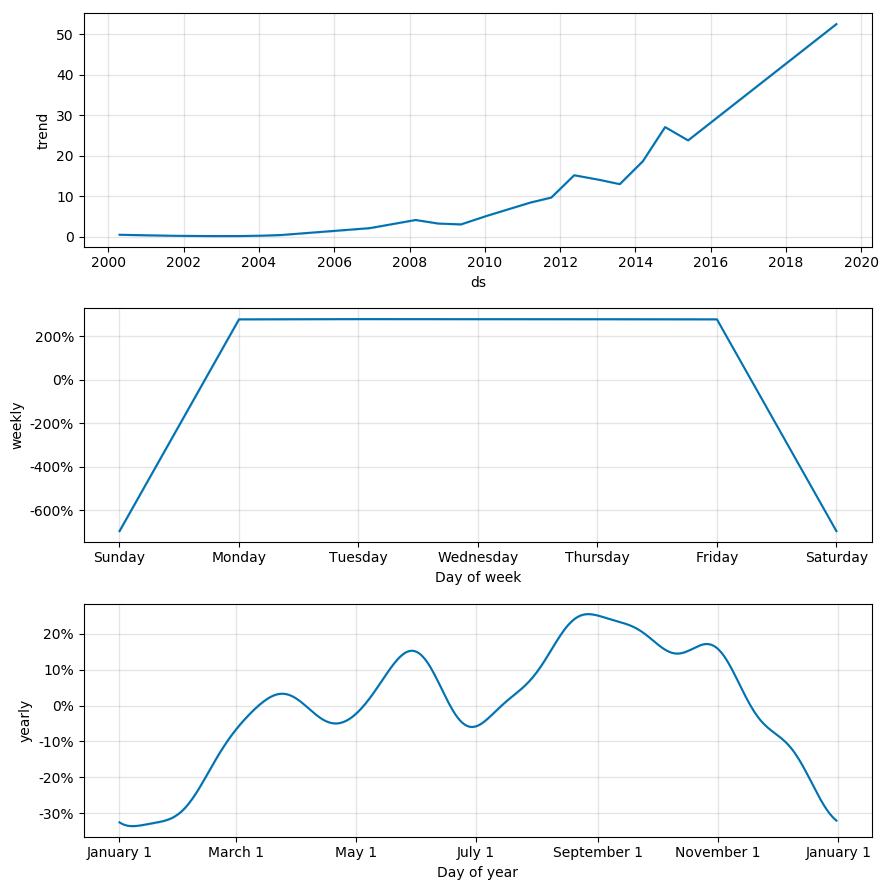

In [34]:
fbm.plot_components(forecast);

In [35]:
# Create mask that asks if the differential on the trend is upwards
mask = forecast['trend'].diff().iloc[-10:] > 0

# If they're all true 
if mask.all() == True:
    # Prophet thinks we're on the way down
    prophet_signal = 1
else:
    # Prophet thinks we're on the way up
    prophet_signal = 0

In [36]:
mask

4799    True
4800    True
4801    True
4802    True
4803    True
4804    True
4805    True
4806    True
4807    True
4808    True
Name: trend, dtype: bool

# WaveNet

### Build and Validate a Trading Algorithm

We can take a number of approaches, but the simplest is to buy if next week's prediction is higher and sell if it's lower.

Assumptions:
 - we start enough funds for one stock
 - no put options
 - fixed transaction cost regardless of volume bought or sold
 - only make money buying low and selling high
 - opportunity cost in the bull market is buying and sitting till end of timeframe

In [ ]:
# predict across span of time
pred = model1.predict(data)
pred[:5]

In [ ]:
data

In [ ]:
# pull true values
true = data['final_close1']
true[:5]

In [ ]:
# if predicted is higher than current close, buy
#def profits(data, pred, true):
tally = []
transactions = 0
invested = False
cash = 0

for i in range(len(true)):
    if pred[i] > data['Close'][i] and invested == False: # buy and flag as invested
        invested = True
        transactions +=1
        buy_price = data['Close'][i]
        print('buy: $' + str(buy_price))
    elif pred[i] > data['Close'][i] and invested == True:
        continue
    elif pred[i] < data['Close'][i] and invested == True:
        tally.append(true[i] - buy_price)
        invested = False
        transactions +=1
        print(true[i] - buy_price)
    else:
        print('wait')

In [ ]:
len(tally)

In [ ]:
len(true)

In [ ]:
transactions

In [ ]:
sum(tally)

# we made close to $100

In [ ]:
plt.hist(tally);

In [ ]:
# compare to buy and hold
data['Close'][-1] - data['Close'][0]

Our trading strategy nets us **$99$ - $86$ =**

**$13 /stock**

We haven't taken the 62 transactions into account, but at a fixed price, the variable profit should compensate. In a bull market, like AAPL and other stocks experienced during 2014-2018, it's easy to make money using most any strategy. The real test is during periods of variability or correction. We can pull relevant time periods, but should ALWAYS remember to retrain our model when market conditions experience fundamental shifts. 

## Additional Resources

Many thanks to my amazing colleague [Joe Eddy]() for his informative blog posts on WaveNet:
- [Time Series Forecasting with Convolutional Neural Networks - a Look at WaveNet](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/)
- [Time Series Forecasting with Convolutional Neural Networks - Further Exploration of WaveNet](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv2/)
- Optional context: [Forecasting with Neural Networks - An Introduction to Sequence-to-Sequence Modeling Of Time Series](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/)

